In [36]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

In [2]:
df = pd.read_csv("cardio_train.csv", sep=";")

In [3]:
df.drop(columns=["id"],inplace=True)

In [4]:
df["age_years"] = df["age"] / 365.25
df.drop(columns=["age"],inplace=True)

In [6]:
df["BMI"] = df["weight"] / (df["height"]/100)**2
df.drop(columns=["weight"],inplace=True)
df.drop(columns=["height"],inplace=True)

In [7]:
df = df[(df["ap_hi"] >= 50) & (df["ap_hi"] <= 250)]
df = df[(df["ap_lo"] >= 30) & (df["ap_lo"] <= 200)]
df = df[df["ap_hi"] >= df["ap_lo"]]

In [8]:
df = df[(df["BMI"] > 10) & (df["BMI"] < 60)]

In [9]:
X = df.drop(columns=["cardio"])
y = df["cardio"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [12]:
continuous = ["age_years","BMI", "ap_hi", "ap_lo"]

scaler = RobustScaler()

X_train[continuous] = scaler.fit_transform(X_train[continuous])
X_test[continuous]  = scaler.transform(X_test[continuous])

# Supervised ML

## XGBoost

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [14]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

In [20]:
xgb.fit(X_train ,y_train)
y_pred_xgb = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.7267361364133207
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6934
           1       0.74      0.69      0.71      6789

    accuracy                           0.73     13723
   macro avg       0.73      0.73      0.73     13723
weighted avg       0.73      0.73      0.73     13723



## Random Forest

In [16]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,12
,min_samples_split,4
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
y_pred_rf = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print(classification_report(y_test, y_pred_rf))


Accuracy: 0.7301610435036071
F1: 0.7140319715808171
ROC-AUC: 0.79500383070172
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6934
           1       0.75      0.68      0.71      6789

    accuracy                           0.73     13723
   macro avg       0.73      0.73      0.73     13723
weighted avg       0.73      0.73      0.73     13723



In [22]:
importances = rf.feature_importances_
feat_names = X_train.columns

fi = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(fi)


       feature  importance
1        ap_hi    0.416455
2        ap_lo    0.186274
8    age_years    0.172602
9          BMI    0.096593
3  cholesterol    0.079087
4         gluc    0.016144
7       active    0.011462
0       gender    0.008994
5        smoke    0.006856
6         alco    0.005533


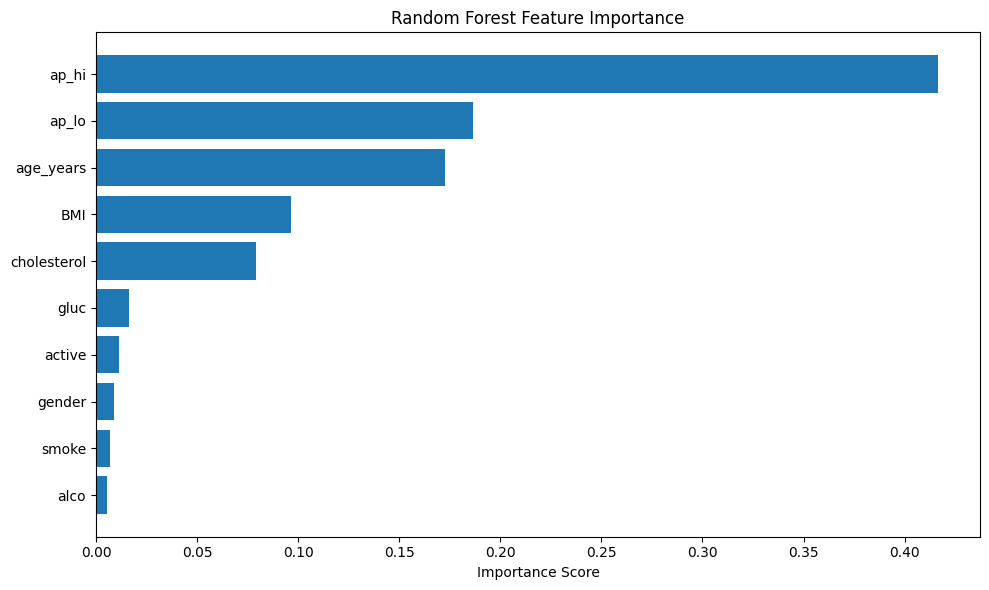

In [23]:
plt.figure(figsize=(10, 6))
plt.barh(fi['feature'], fi['importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [27]:
LR = LogisticRegression(
    penalty="l2",          
    C=1.0,                
    solver="lbfgs",        
    n_jobs=-1
)

LR.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [28]:
y_pred_LR = LR.predict(X_test)
y_proba_LR = LR.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_LR))
print("F1:", f1_score(y_test, y_pred_LR))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_LR))

print(classification_report(y_test, y_pred_LR))


Accuracy: 0.7233112293230344
F1: 0.7036603449621478
ROC-AUC: 0.7843135005671595
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      6934
           1       0.75      0.66      0.70      6789

    accuracy                           0.72     13723
   macro avg       0.73      0.72      0.72     13723
weighted avg       0.73      0.72      0.72     13723



In [29]:
coef = LR.coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef,
}).sort_values("coefficient", ascending=False)

print(coef_df)


       feature  coefficient
1        ap_hi     1.150161
8    age_years     0.515918
3  cholesterol     0.482364
9          BMI     0.163919
2        ap_lo     0.105165
0       gender     0.034539
4         gluc    -0.116668
5        smoke    -0.162985
6         alco    -0.220284
7       active    -0.248525


## stratified 5-fold cross-validation with AUC-ROC scores 

In [32]:
models = {
    "XGBoost": xgb,
    "Random Forest": rf,
    "Logistic Regression": LR
}

In [34]:
auc_results = {name: [] for name in models}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_prob)
        auc_results[name].append(auc)


In [35]:

for name in auc_results:
    print(f"{name} AUC scores: {auc_results[name]}")
    print(f"{name} Mean AUC: {np.mean(auc_results[name]):.4f}\n")

XGBoost AUC scores: [0.7921693068620013, 0.7932421072738383, 0.7964429407706345, 0.7945632307477988, 0.7930059776956967]
XGBoost Mean AUC: 0.7939

Random Forest AUC scores: [0.8004330904311989, 0.7994913364282293, 0.8025087389409811, 0.8012268469431879, 0.7995928115871678]
Random Forest Mean AUC: 0.8007

Logistic Regression AUC scores: [0.7369615939491865, 0.7874544295619286, 0.7871526340795522, 0.784484055529965, 0.7847345009639961]
Logistic Regression Mean AUC: 0.7762



## CALIBRATION CURVES

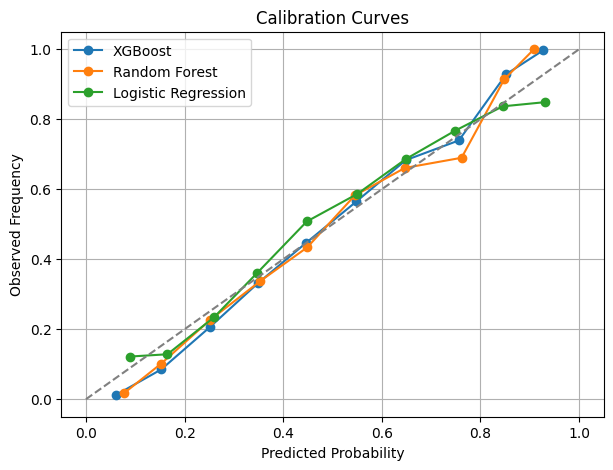

In [37]:
plt.figure(figsize=(7, 5))

for name, model in models.items():
    model.fit(X, y)
    prob = model.predict_proba(X)[:, 1]

    frac_pos, mean_pred = calibration_curve(y, prob, n_bins=10)

    plt.plot(mean_pred, frac_pos, marker='o', label=name)

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curves")
plt.legend()
plt.grid(True)
plt.show()